In [12]:
import os

import pandas as pd
import re
from pathlib import Path
import IPython.display as ipd

import __libpath
from psychelibrary import nic_dataset_tools as ndt

from pydub import AudioSegment, silence
from pydub.playback import play

from statsmodels.multivariate.manova import MANOVA
import matplotlib.pyplot as plt

In [13]:
dialog= pd.read_pickle("../Preprocessing/Save/IEMOCAP/dialog.pkl")
content= pd.read_pickle("../Preprocessing/Save/IEMOCAP/content_processed.pkl")

In [14]:
dialog.describe()

,start_time,end_time,session,duration
count,151.000000,151.000000,151.000000,151.000000
mean,5.450914,271.816368,3.039735,266.365454
std,2.184570,97.971156,1.404188,97.826767
min,0.462100,82.387500,1.000000,78.287500
25%,3.835000,202.596250,2.000000,197.081150
50%,5.270000,251.950000,3.000000,247.330000
75%,6.708850,344.103250,4.000000,337.338250
max,12.940000,542.269100,5.000000,540.419100


In [15]:
# How many hours?
dialog['duration'].sum()/(60*60)

11.172550972222222

It's 11 hours of net recordings with words. In total, as reported in the paper it is 12 hours of recordings.

In [16]:
content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10036 entries, 0 to 10038
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   start_time              10036 non-null  float64
 1   end_time                10036 non-null  float64
 2   turn_name               10036 non-null  object 
 3   emotion                 10036 non-null  object 
 4   valence                 10036 non-null  float64
 5   activation              10036 non-null  float64
 6   dominance               10036 non-null  float64
 7   session                 10036 non-null  int64  
 8   conversation_id         10036 non-null  object 
 9   conversation_type       10036 non-null  object 
 10  leading_dialog_actor    10036 non-null  object 
 11  secondary_dialog_actor  10036 non-null  object 
 12  actor_speaking_id       10036 non-null  object 
 13  transcription           10036 non-null  object 
 14  wav_path                10036 non-null

In [17]:
content.describe()

,start_time,end_time,valence,activation,dominance,session,duration
count,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000
mean,143.573049,148.032994,2.777916,3.089893,3.194633,3.099243,4.459944
std,100.306666,100.638243,0.897242,0.701804,0.788888,1.403432,3.064793
min,0.462100,3.002500,1.000000,1.000000,0.500000,1.000000,0.585000
25%,62.247575,66.911050,2.000000,2.500000,2.500000,2.000000,2.330000
50%,127.344550,132.260000,2.500000,3.000000,3.000000,3.000000,3.520000
75%,205.460000,209.326250,3.500000,3.500000,4.000000,4.000000,5.710000
max,539.575800,542.269100,5.500000,5.000000,5.000000,5.000000,34.138800


In [18]:
content.describe(include=object)

,turn_name,emotion,conversation_id,conversation_type,leading_dialog_actor,secondary_dialog_actor,actor_speaking_id,transcription,wav_path,alignment_path,...,label_1,other_label_1,label_2,other_label_2,label_3,other_label_3,self_label,self_other_label,conversation_wav_path,emotion_label
count,10036,10036,10036,10036,10036,10036,10036,10036,10036,10036,...,10036,10036,10036,10036,10036,10036,2414,2414,10036,10036
unique,10036,10,151,2,10,10,10,8065,10036,10036,...,35,18,44,33,52,48,77,111,151,9
top,Ses01F_impro01_F000,xxx,Ses04F_impro07,script,M3,F3,M5,Yeah.,D:\OneDrive - Universiteit Utrecht\Documents\0...,D:\OneDrive - Universiteit Utrecht\Documents\0...,...,Frustration,,Anger,,Neutral,,Neutral,,D:\OneDrive - Universiteit Utrecht\Documents\0...,fru
freq,1,2507,167,5253,1178,1178,1137,84,1,1,...,3690,9979,2048,9942,3790,9404,501,2102,167,1890


In [19]:
content.head()

,start_time,end_time,turn_name,emotion,valence,activation,dominance,session,conversation_id,conversation_type,...,other_label_1,label_2,other_label_2,label_3,other_label_3,self_label,self_other_label,duration,conversation_wav_path,emotion_label
0,6.2901,8.2357,Ses01F_impro01_F000,neu,2.5,2.5,2.5,1,Ses01F_impro01,impro,...,,Neutral,,Neutral,,Neutral,curious,1.9456,D:\OneDrive - Universiteit Utrecht\Documents\0...,neu
1,10.0100,11.3925,Ses01F_impro01_F001,neu,2.5,2.5,2.5,1,Ses01F_impro01,impro,...,,Neutral,,Neutral,,Neutral; Anger,,1.3825,D:\OneDrive - Universiteit Utrecht\Documents\0...,neu
2,14.8872,18.0175,Ses01F_impro01_F002,neu,2.5,2.5,2.5,1,Ses01F_impro01,impro,...,,Surprise,,Neutral,,Neutral; Anger,,3.1303,D:\OneDrive - Universiteit Utrecht\Documents\0...,neu
3,19.2900,20.7875,Ses01F_impro01_F003,xxx,2.5,3.0,3.0,1,Ses01F_impro01,impro,...,,Frustration,,Anger,,Frustration; Anger,,1.4975,D:\OneDrive - Universiteit Utrecht\Documents\0...,ang
4,21.3257,24.7400,Ses01F_impro01_F004,xxx,2.5,3.0,2.5,1,Ses01F_impro01,impro,...,,Frustration; Disgust,,Anger,,Frustration; Anger,,3.4143,D:\OneDrive - Universiteit Utrecht\Documents\0...,ang


In [20]:
mask = content['turn_name'].str.contains('Ses03F_impro05')
content.loc[mask][['start_time', 'end_time', 'turn_name', 'emotion', 'transcription']].sort_values('start_time')

,start_time,end_time,turn_name,emotion,transcription
3825,6.3183,13.3161,Ses03F_impro05_F000,fru,"Look sir, I've been waiting for about an hour ..."
3843,12.9085,20.6762,Ses03F_impro05_M000,fru,"I'm sorry, Mrs. Rosenkrantz, but uh- I don't k..."
3826,20.6762,29.5536,Ses03F_impro05_F001,fru,"What do you mean, you don't know what to tell ..."
3844,25.5850,29.9500,Ses03F_impro05_M001,fru,Did you- Did you check with the lost and found?
3827,29.6894,33.1543,Ses03F_impro05_F002,ang,Where? I don't know. The lost and found. What ...
3828,33.1770,39.4875,Ses03F_impro05_F003,fru,I had my luggage transferred here from Paris t...
3845,38.3875,42.4620,Ses03F_impro05_M002,fru,"Maybe it got lost. Did you think about that, mom?"
3829,42.1223,46.3119,Ses03F_impro05_F004,fru,"Well, that's what I'm asking you. What--I don'..."
3846,45.2702,51.6338,Ses03F_impro05_M003,neu,"Oh, not--we didn't lose it; maybe the airport ..."
3830,50.7732,58.0654,Ses03F_impro05_F005,ang,"Wait, sir. You're- You're completely not--what..."


## Search for tags in brackets:

In [21]:
mask = content['transcription'].str.contains('\[')
content.loc[mask][['transcription', "turn_name"]]

,transcription,turn_name
71,Chuck. [LAUGHTER],Ses01F_impro03_F003
81,I guess I'll- I guess I'll have an internet h...,Ses01F_impro03_F013
83,"Yeah, so [LAUGHTER] He's calling me now",Ses01F_impro03_F015
94,She needs a new name each state that we go int...,Ses01F_impro03_F026
102,[LAUGHTER] That's really romantic.,Ses01F_impro03_M007
...,...,...
9943,"[LAUGHTER] That was quit a rouser, wasn't it?",Ses05M_script03_1_M030
9945,I should never forget his face. [LAUGHTER],Ses05M_script03_1_M032
9951,"[garbage], No, I didn't. You worked the whole...",Ses05M_script03_2_F003
9972,[LAUGHTER] Mind your own business.,Ses05M_script03_2_F024


In [22]:
ndt.print_iemocap_turn_wav(content, 'Ses05M_script03_1_M030')

In [23]:
# Extract all words inside square brackets [] from the 'transcription' column and flatten the list
words = content['transcription'].apply(lambda x: re.findall(r'\[(.*?)\]', x)).explode()

# Count the occurrences of each word
word_counts = words.value_counts()

print(word_counts)

LAUGHTER     166
BREATHING     57
GARBAGE       32
garbage       14
LIPSMACK       1
laughter       1
Name: transcription, dtype: int64


### Breathing is labeled!

In [24]:
mask = content['transcription'].str.contains('\[BREATHING')
content.loc[mask][['transcription', "turn_name"]]

,transcription,turn_name
418,"All right, then, Mom. [BREATHING]",Ses01F_script01_1_M031
449,[BREATHING] You don't look at me like that. H...,Ses01F_script01_2_M003
458,[BREATHING],Ses01F_script01_2_M012
466,"[BREATHING] You know, it's lovely here. The a...",Ses01F_script01_3_F002
474,[BREATHING],Ses01F_script01_3_F010
540,[BREATHING],Ses01F_script02_1_F001
639,[BREATHING],Ses01F_script02_2_F029
693,[BREATHING],Ses01F_script02_2_M035
701,[BREATHING],Ses01F_script02_2_M043
704,[BREATHING],Ses01F_script02_2_M046


In [25]:
ndt.print_iemocap_turn_wav(content, 'Ses01F_script03_1_M003')

### We could consider the labeled breathing as filled paused breathing. It is a type of exaggerated breathing used as reaction.

In [26]:
mask = content['transcription'].str.contains('\[LIPSMACK')
content.loc[mask][['transcription', "turn_name"]]

,transcription,turn_name
275,It was hot.[LIPSMACK],Ses01F_impro06_F017


In [27]:
ndt.print_iemocap_turn_wav(content, 'Ses01F_impro06_F017')

### The labeled lipsmack sounds more like a laughter to me... More context is needed though.

In [28]:
ndt.print_iemocap_turn_wav(content, 'Ses01F_impro06_M016')
ndt.print_iemocap_turn_wav(content, 'Ses01F_impro06_F017')

## Let's now search for other stuff

In [29]:
# Extract all words inside round brackets () from the 'transcription' column and flatten the list
words = content['transcription'].apply(lambda x: re.findall(r'\((.*?)\)', x)).explode()

# Count the occurrences of each word
word_counts = words.value_counts()

print(word_counts)

Series([], Name: transcription, dtype: int64)


In [30]:
# SEARCHING FOR LAUGHs THAT ARE WRITTEN AS "ahahahah"
words = content['transcription'].apply(lambda x: re.findall(r'\b(ah)+\b', x)).explode()

# Count the occurrences of each word
word_counts = words.value_counts()

print(word_counts)

ah    11
Name: transcription, dtype: int64


In [31]:
# SEARCHING FOR FILLED PAUSES

sound_filled_pauses = [
    "ah", "eh", "mm", "oo", "uh", "er", "um", "oh", 
    "ooh", "eeh", "ohh", "ehh", "ahh", "hum", "huh", "mhm", "erm", "huh", "shh", "uhm", "ehm", "uhh", "hmm",
    "uhuh", "oops", "phew", "psst", "yoo-hoo", "zing", "yikes", "uh-huh", "ouch", "tsk-tsk", "uh-oh", "ahem", "mmhmm",
    "argh", "urgh"
]


word_filled_pauses = [
    "well", "so", "you know", "okay", "right", "you see", "I mean", "i mean",
    "actually", "basically", "essentially", "let me think"
]

filled_pauses = sound_filled_pauses #+ word_filled_pauses

pattern = r'\b(' + '|'.join(filled_pauses) + r')\b'

words = content['transcription'].apply(lambda x: re.findall(pattern, x)).explode()

# Count the occurrences of each word
word_counts = words.value_counts()

print(word_counts)

um       126
uh       103
oh        72
huh       46
hmm       11
ah        11
ahh        8
ooh        5
mmhmm      3
uhh        2
eh         2
uhuh       1
urgh       1
mm         1
oops       1
er         1
hum        1
Name: transcription, dtype: int64


# Emotions exploration

In [32]:
content['emotion'].value_counts()

xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
dis       2
Name: emotion, dtype: int64

In [33]:
content.loc[content['emotion'] == 'oth']

,start_time,end_time,turn_name,emotion,valence,activation,dominance,session,conversation_id,conversation_type,...,other_label_1,label_2,other_label_2,label_3,other_label_3,self_label,self_other_label,duration,conversation_wav_path,emotion_label


In [34]:
content.loc[content['emotion'] == 'oth'][['turn_name','transcription']]

,turn_name,transcription


In [35]:
content.loc[content['emotion'] == 'dis']

,start_time,end_time,turn_name,emotion,valence,activation,dominance,session,conversation_id,conversation_type,...,other_label_1,label_2,other_label_2,label_3,other_label_3,self_label,self_other_label,duration,conversation_wav_path,emotion_label
770,219.22,221.82,Ses01F_script03_1_M030,dis,3.0,2.0,2.0,1,Ses01F_script03_1,script,...,,Disgust,,Disgust,,NaN,NaN,2.60,D:\OneDrive - Universiteit Utrecht\Documents\0...,dis
4852,131.91,134.00,Ses03M_impro04_M015,dis,2.5,2.0,1.5,3,Ses03M_impro04,impro,...,,Disgust,,Disgust,,Frustration,,2.09,D:\OneDrive - Universiteit Utrecht\Documents\0...,dis


In [36]:
content.loc[content['emotion'] == 'dis'][['turn_name','transcription']]

,turn_name,transcription
770,Ses01F_script03_1_M030,It was a terrible thing. I hated it.
4852,Ses03M_impro04_M015,I don't want to be a law clerk.


# Emotion coordinates and statistical differences

In [37]:
# Exclude rows with 'xxx' emotion
content_filtered = content[content['emotion'] != 'xxx']

# Compute the mean for each emotion
mean_emotions = content_filtered.groupby('emotion')[['valence', 'activation', 'dominance']].mean()
print(mean_emotions)

          valence  activation  dominance
emotion                                 
ang      1.905712    3.635539   3.949834
dis      2.750000    2.000000   1.750000
exc      3.945085    3.578370   3.402578
fea      2.504165    3.241665   2.366668
fru      2.262394    3.184874   3.321706
hap      3.951260    3.118488   2.923809
neu      2.971361    2.725752   2.830553
sad      2.253075    2.563499   2.827952
sur      2.845015    3.217290   2.854362


## MANOVA on the difference between them

In [38]:
# Construct the dependent variable dataframe
dv = pd.DataFrame({
    'valence': content_filtered['valence'],
    'activation': content_filtered['activation'],
    'dominance': content_filtered['dominance']
})

# Run the MANOVA
manova = MANOVA.from_formula('valence + activation + dominance ~ emotion', data=content_filtered)
print(manova.mv_test())
print()

subset_emotions = ['hap', 'sad']
print("MANOVA FOR SUBSET:")
print(subset_emotions)
# MANOVA for subset of emotions, for example, only for "happy" and "sad" emotions:
subset = content_filtered[content_filtered['emotion'].isin(subset_emotions)]
manova_subset = MANOVA.from_formula('valence + activation + dominance ~ emotion', data=subset)
print(manova_subset.mv_test())

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
        Intercept        Value  Num DF   Den DF   F Value   Pr > F
------------------------------------------------------------------
           Wilks' lambda 0.0962 3.0000 7518.0000 23533.9956 0.0000
          Pillai's trace 0.9038 3.0000 7518.0000 23533.9956 0.0000
  Hotelling-Lawley trace 9.3911 3.0000 7518.0000 23533.9956 0.0000
     Roy's greatest root 9.3911 3.0000 7518.0000 23533.9956 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
        emotion         Value   Num DF   Den DF    F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.2437 24.0000 21805.0885  569.7600 0.0000
         Pillai'

### The emotion label is statistically significant in explaining the variance across the Valence, Activation, Dominance space. This happens both for all the emotions and the subset (Sadness, Happiness).

In [39]:
subset_emotions = ['fru', 'ang']
print("MANOVA FOR SUBSET:")
print(subset_emotions)
# MANOVA for subset of emotions, for example, only for "happy" and "sad" emotions:
subset = content_filtered[content_filtered['emotion'].isin(subset_emotions)]
manova_subset = MANOVA.from_formula('valence + activation + dominance ~ emotion', data=subset)
print(manova_subset.mv_test())

MANOVA FOR SUBSET:
['fru', 'ang']
                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept         Value  Num DF   Den DF   F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda  0.0258 3.0000 2948.0000 37088.6633 0.0000
         Pillai's trace  0.9742 3.0000 2948.0000 37088.6633 0.0000
 Hotelling-Lawley trace 37.7429 3.0000 2948.0000 37088.6633 0.0000
    Roy's greatest root 37.7429 3.0000 2948.0000 37088.6633 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
           emotion         Value  Num DF   Den DF  F Value  Pr > F
------------------------------------------------------------------
             Wilks' lambda 0.8152 3.0000 2948.000

### Also between Frustration and Anger there is a significant difference, although little.

# Duration exploration

In [41]:
content['duration'].describe()

count    10036.000000
mean         4.459944
std          3.064793
min          0.585000
25%          2.330000
50%          3.520000
75%          5.710000
max         34.138800
Name: duration, dtype: float64

We for sure need to delete too short turns.

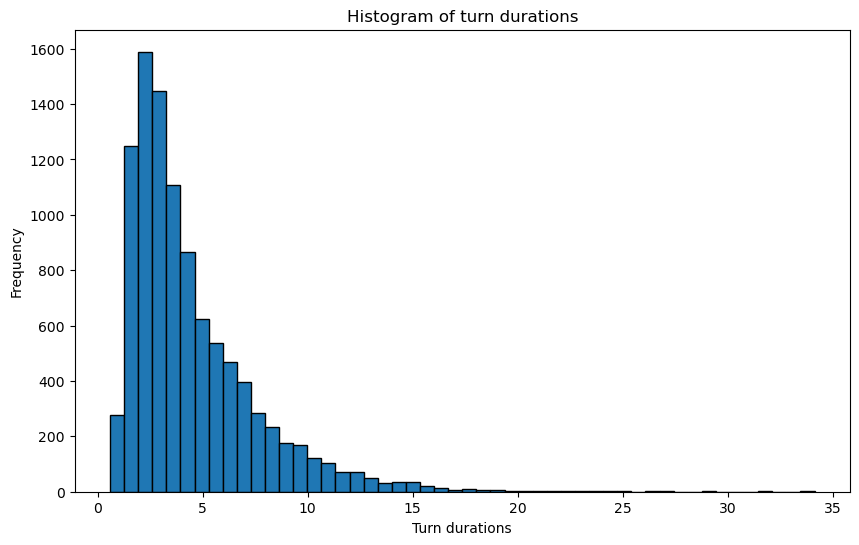

In [43]:
plt.figure(figsize=(10,6))
plt.hist(content['duration'], bins=50, edgecolor='black')
plt.title('Histogram of turn durations')
plt.xlabel('Turn durations')
plt.ylabel('Frequency')
plt.show()

Total entries: 6906
Percentage of dataset:
0.6881227580709446


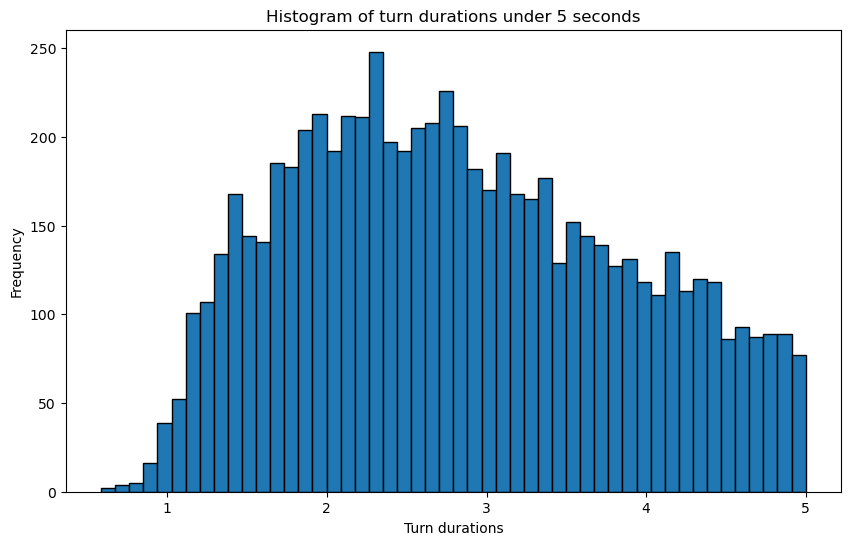

In [44]:
under5 = content.loc[content['duration'] < 5]
print("Total entries:", str(len(under5)))
print("Percentage of dataset:")
print(len(under5) / len(content))

plt.figure(figsize=(10,6))
plt.hist(under5['duration'], bins=50, edgecolor='black')
plt.title('Histogram of turn durations under 5 seconds')
plt.xlabel('Turn durations')
plt.ylabel('Frequency')
plt.show()

In [45]:
def subset_maxduration_stats(content, seconds_threshold):
    under = content.loc[content['duration'] < seconds_threshold]
    print("Total entries:", str(len(under)))
    print("Percentage of dataset:")
    print(str(len(under) / len(content) *100), '%')

In [46]:
subset_maxduration_stats(content, 2)

Total entries: 1699
Percentage of dataset:
16.929055400557992 %


In [47]:
subset_maxduration_stats(content, 1.8)

Total entries: 1234
Percentage of dataset:
12.295735352730171 %


In [48]:
subset_maxduration_stats(content, 1.5)

Total entries: 684
Percentage of dataset:
6.815464328417696 %


In [49]:
subset_maxduration_stats(content, 1)

Total entries: 50
Percentage of dataset:
0.49820645675567954 %


### We could delete entries under 1.5 seconds which means deleting 7% of our entire dataset, or:

In [50]:
print(str(11 * 0.068 * 60), 'minutes of data')

44.88 minutes of data


### leaving us with around 10 hours of net data.

In [51]:
def subset_minduration_stats(content, seconds_threshold):
    over = content.loc[content['duration'] > seconds_threshold]
    print("Total entries:", str(len(over)))
    print("Percentage of dataset:")
    print(str(len(over) / len(content) *100), '%')

Total entries: 3129
Percentage of dataset:
31.177760063770428 %


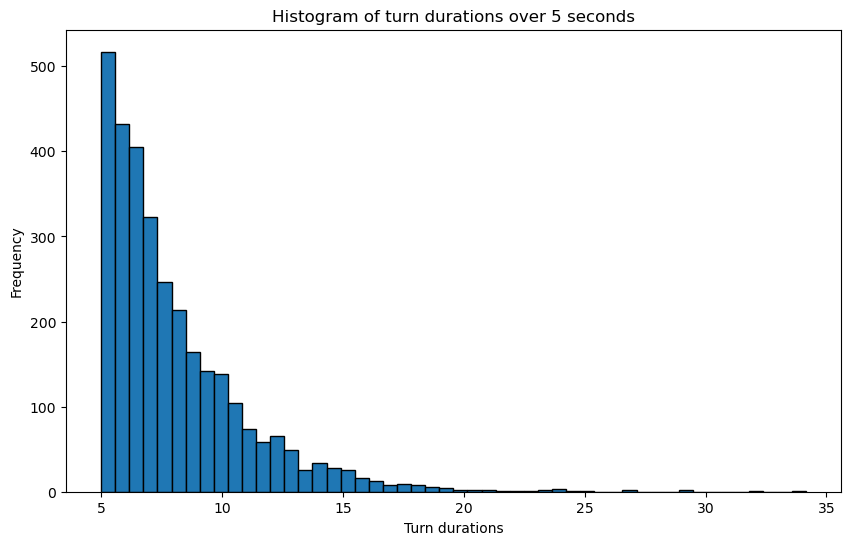

In [55]:
over5 = content.loc[content['duration'] > 5]
subset_minduration_stats(content, 5)

plt.figure(figsize=(10,6))
plt.hist(over5['duration'], bins=50, edgecolor='black')
plt.title('Histogram of turn durations over 5 seconds')
plt.xlabel('Turn durations')
plt.ylabel('Frequency')
plt.show()

In [56]:
subset_minduration_stats(content, 10)

Total entries: 603
Percentage of dataset:
6.008369868473496 %


In [57]:
subset_minduration_stats(content, 20)

Total entries: 21
Percentage of dataset:
0.20924671183738544 %


In [58]:
subset_minduration_stats(content, 30)

Total entries: 2
Percentage of dataset:
0.01992825827022718 %


### We could also split entries with duration over 20 seconds for the model to have better balance.

### Another solution is to re-do the segmentation with more distributed divisions depending on breath labels, as with interspeech.

# I found that some files may miss the alignment

## Let's check that:

In [59]:
mask = content['alignment_path'].apply(lambda x: not os.path.isfile(x))
no_alignment_subset = content[mask]

In [60]:
no_alignment_subset

,start_time,end_time,turn_name,emotion,valence,activation,dominance,session,conversation_id,conversation_type,...,other_label_1,label_2,other_label_2,label_3,other_label_3,self_label,self_other_label,duration,conversation_wav_path,emotion_label
3977,171.1083,175.6950,Ses03F_impro07_M030,xxx,4.0,3.5,2.5,3,Ses03F_impro07,impro,...,,Neutral,,Happiness,,Excited,,4.5867,D:\OneDrive - Universiteit Utrecht\Documents\0...,exc
4764,4.0436,7.3747,Ses03M_impro03_M001,exc,4.0,4.0,3.0,3,Ses03M_impro03,impro,...,,Happiness,,Excited,,Excited,,3.3311,D:\OneDrive - Universiteit Utrecht\Documents\0...,exc


Two files are missing the alignment. When processing it is important to think about what to do with them